# Нейросети для предсказания временных рядов

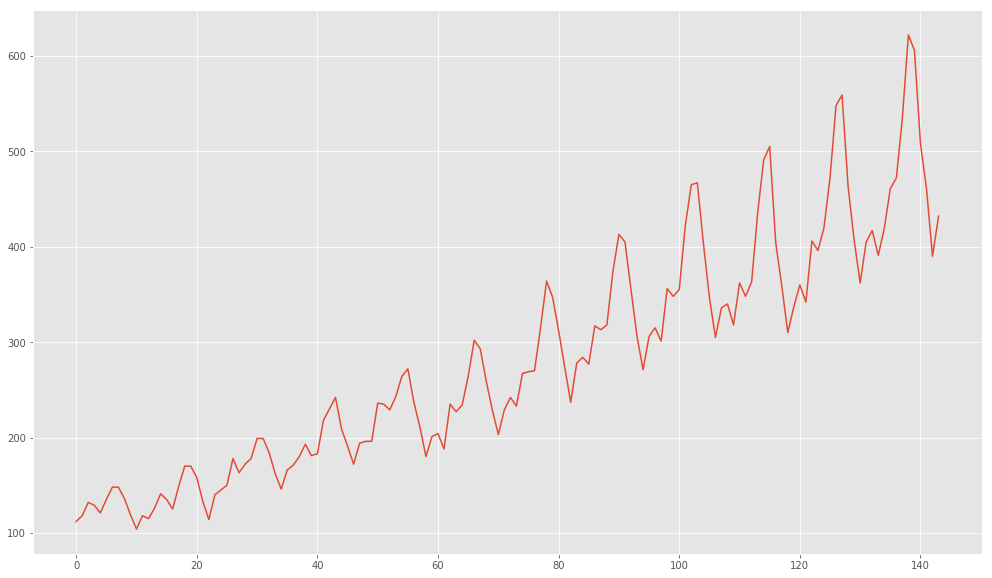

In [84]:
import pandas
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 17, 10 # задаём размер графика 

dataset = pandas.read_csv('https://github.com/lazyprogrammer/machine_learning_examples/raw/master/airline/international-airline-passengers.csv', 
                          usecols=[1], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [85]:
import os
os.environ['KERAS_BACKEND'] = 'theano' # подключение библиотеки theano в качестве "движка" для keras
from keras import backend as K # необходимо для некоторых операций

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# зафиксируем random_state для дальнейшей воспроизводимости эксперимента
numpy.random.seed(7)

dataset = dataset.values # Keras умеет хавать только numpy-матрицы
dataset = dataset.astype('float32')


# приведём все данные к интервалу значений от 0 до 1 (нормализуем)
# В принципе, если вы не используете регуляризацию, то можно не нормировать - результат будет тот же
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# разобьём данные на трейн и тест. 
# В задачах предсказания временный рядов это нужно делать осторожно, чтобы случайно не перемешать порядок данных!
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


# сконвертируем данные таким образом, чтобы для каждого временного тика (начиная с look_back) были добавлены 
# признаки для look_back предыдущих состояний
def create_dataset(dataset, look_back=1): # look_back - по какому количеству тиков времени мы собираемся предсказывать следующий
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0] # берём все тики времени от i до i + look_back не включая
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

96 48


In [86]:
trainX = numpy.reshape(trainX, (trainX.shape[0], -1))
testX = numpy.reshape(testX, (testX.shape[0], -1))

In [65]:
# А вот и вся наша нейросетка :)
model = Sequential()
model.add(Dense(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=10, verbose=2)

Epoch 1/100
 - 0s - loss: 0.0076
Epoch 2/100
 - 0s - loss: 0.0055
Epoch 3/100
 - 0s - loss: 0.0051
Epoch 4/100
 - 0s - loss: 0.0045
Epoch 5/100
 - 0s - loss: 0.0043
Epoch 6/100
 - 0s - loss: 0.0041
Epoch 7/100
 - 0s - loss: 0.0039
Epoch 8/100
 - 0s - loss: 0.0039
Epoch 9/100
 - 0s - loss: 0.0034
Epoch 10/100
 - 0s - loss: 0.0033
Epoch 11/100
 - 0s - loss: 0.0028
Epoch 12/100
 - 0s - loss: 0.0027
Epoch 13/100
 - 0s - loss: 0.0029
Epoch 14/100
 - 0s - loss: 0.0030
Epoch 15/100
 - 0s - loss: 0.0025
Epoch 16/100
 - 0s - loss: 0.0024
Epoch 17/100
 - 0s - loss: 0.0024
Epoch 18/100
 - 0s - loss: 0.0023
Epoch 19/100
 - 0s - loss: 0.0021
Epoch 20/100
 - 0s - loss: 0.0022
Epoch 21/100
 - 0s - loss: 0.0023
Epoch 22/100
 - 0s - loss: 0.0019
Epoch 23/100
 - 0s - loss: 0.0023
Epoch 24/100
 - 0s - loss: 0.0020
Epoch 25/100
 - 0s - loss: 0.0021
Epoch 26/100
 - 0s - loss: 0.0021
Epoch 27/100
 - 0s - loss: 0.0021
Epoch 28/100
 - 0s - loss: 0.0020
Epoch 29/100
 - 0s - loss: 0.0020
Epoch 30/100
 - 0s - lo

In [66]:
# получим предсказания
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# преобразуем обратно наши данные из интервала (0, 1) в исходных диапазон значений
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# посчитаем MSE для наших предсказаний
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.72 RMSE
Test Score: 46.03 RMSE


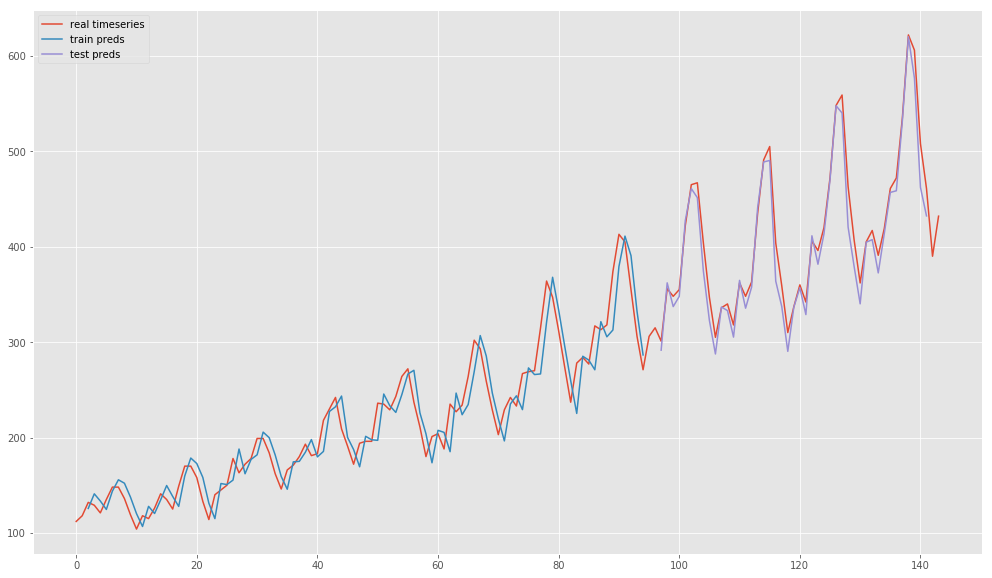

In [67]:
trainPredictPlot = numpy.empty_like(dataset) # предсказания для train'a
trainPredictPlot[:, :] = numpy.nan # заполняем пустыми значениями
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(dataset)-look_back-len(testPredict):len(dataset)-look_back, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='real timeseries')
plt.plot(trainPredictPlot, label='train preds')
plt.plot(testPredictPlot, label='test preds')
plt.legend()
plt.show()

# Рекуррентные нейросети

![](http://www.wildml.com/wp-content/uploads/2015/09/rnn.jpg)

![](http://s0.wp.com/latex.php?latex=%5Cbegin%7Baligned%7D++s_t+%26%3D+%5Ctanh%28Ux_t+%2B+Ws_%7Bt-1%7D%29+%5C%5C++o_t+%26%3D+%5Cmathrm%7Bsoftmax%7D%28Vs_t%29++%5Cend%7Baligned%7D++&bg=ffffff&fg=000&s=0)

![RNN](https://habrastorage.org/web/a9b/1e6/40f/a9b1e640f6264b0a902e851eb5f29e08.png)
![RNN full](https://habrastorage.org/web/5c8/0fa/c22/5c80fac224d449209d888d18ea1111a8.png)

# Попробуем запилить простую RNN для предсказания временных рядов

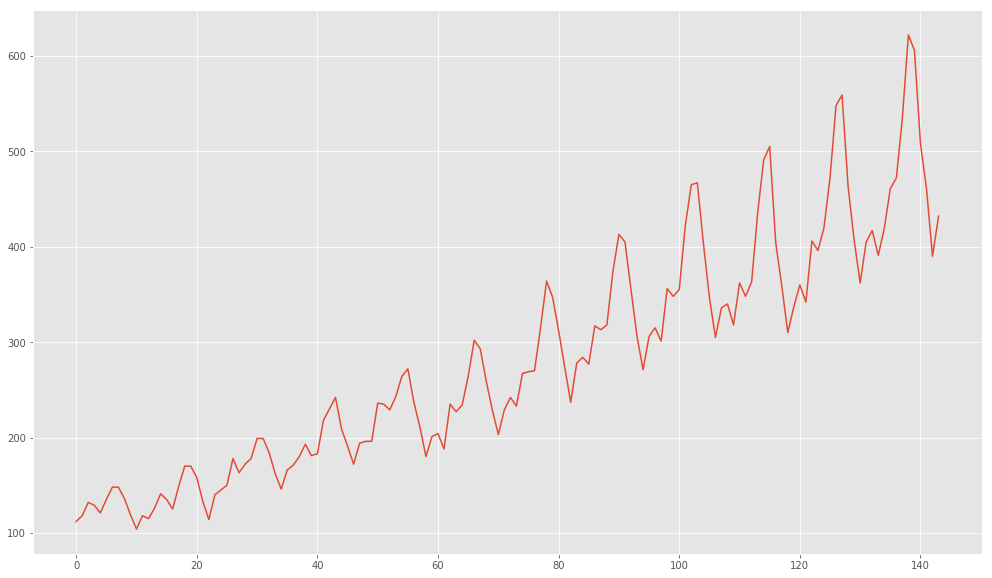

In [68]:
import pandas
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 17, 10 # задаём размер графика 

dataset = pandas.read_csv('https://github.com/lazyprogrammer/machine_learning_examples/raw/master/airline/international-airline-passengers.csv', 
                          usecols=[1], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [69]:
import os
os.environ['KERAS_BACKEND'] = 'theano' # подключение библиотеки theano в качестве "движка" для keras
from keras import backend as K # необходимо для некоторых операций

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# зафиксируем random_state для дальнейшей воспроизводимости эксперимента
numpy.random.seed(7)

dataset = dataset.values # Keras умеет хавать только numpy-матрицы
dataset = dataset.astype('float32')


# приведём все данные к интервалу значений от 0 до 1 (нормализуем)
# В принципе, если вы не используете регуляризацию, то можно не нормировать - результат будет тот же
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# разобьём данные на трейн и тест. 
# В задачах предсказания временный рядов это нужно делать осторожно, чтобы случайно не перемешать порядок данных!
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


# сконвертируем данные таким образом, чтобы для каждого временного тика (начиная с look_back) были добавлены 
# признаки для look_back предыдущих состояний
def create_dataset(dataset, look_back=1): # look_back - по какому количеству тиков времени мы собираемся предсказывать следующий
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0] # берём все тики времени от i до i + look_back не включая
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

96 48


In [70]:
# LSTM и RNN умеет работать с данными в таком формате [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [71]:
# А вот и вся наша нейросетка :)
model = Sequential()
model.add(SimpleRNN(4, batch_input_shape=(1, 1, look_back))) # 4 - размерность выхода, batch_input_shape = [batch_size, features, time steps]
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 0s - loss: 0.2198
Epoch 2/100
 - 0s - loss: 0.0793
Epoch 3/100
 - 0s - loss: 0.0498
Epoch 4/100
 - 0s - loss: 0.0413
Epoch 5/100
 - 0s - loss: 0.0342
Epoch 6/100
 - 0s - loss: 0.0278
Epoch 7/100
 - 0s - loss: 0.0220
Epoch 8/100
 - 0s - loss: 0.0174
Epoch 9/100
 - 0s - loss: 0.0133
Epoch 10/100
 - 0s - loss: 0.0101
Epoch 11/100
 - 0s - loss: 0.0075
Epoch 12/100
 - 0s - loss: 0.0056
Epoch 13/100
 - 0s - loss: 0.0044
Epoch 14/100
 - 0s - loss: 0.0033
Epoch 15/100
 - 0s - loss: 0.0027
Epoch 16/100
 - 0s - loss: 0.0023
Epoch 17/100
 - 0s - loss: 0.0020
Epoch 18/100
 - 0s - loss: 0.0019
Epoch 19/100
 - 0s - loss: 0.0018
Epoch 20/100
 - 0s - loss: 0.0018
Epoch 21/100
 - 0s - loss: 0.0018
Epoch 22/100
 - 0s - loss: 0.0017
Epoch 23/100
 - 0s - loss: 0.0017
Epoch 24/100
 - 0s - loss: 0.0018
Epoch 25/100
 - 0s - loss: 0.0018
Epoch 26/100
 - 0s - loss: 0.0018
Epoch 27/100
 - 0s - loss: 0.0017
Epoch 28/100
 - 0s - loss: 0.0018
Epoch 29/100
 - 0s - loss: 0.0018
Epoch 30/100
 - 0s - lo

In [72]:
# получим предсказания
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# преобразуем обратно наши данные из интервала (0, 1) в исходных диапазон значений
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# посчитаем MSE для наших предсказаний
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.71 RMSE
Test Score: 51.43 RMSE


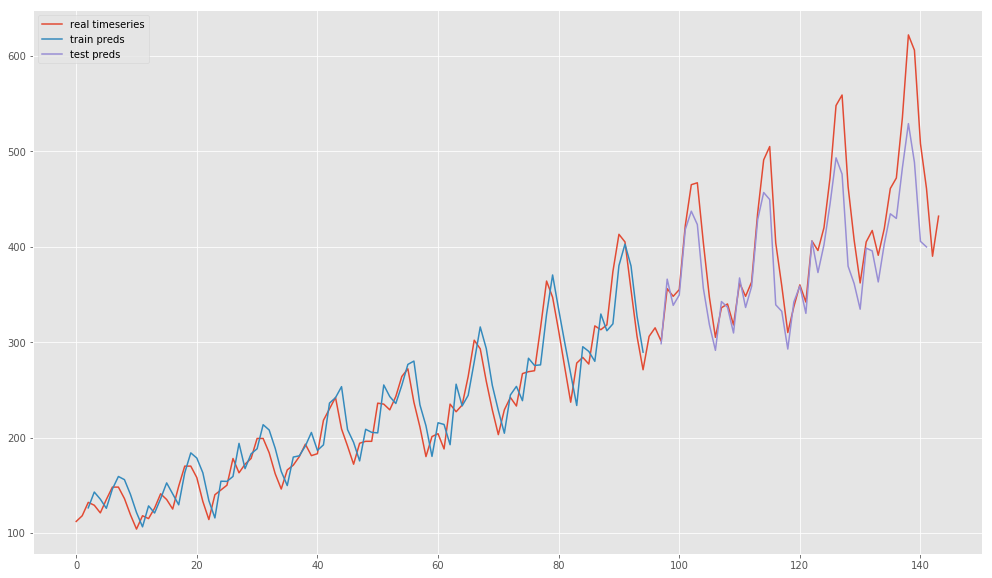

In [73]:
trainPredictPlot = numpy.empty_like(dataset) # предсказания для train'a
trainPredictPlot[:, :] = numpy.nan # заполняем пустыми значениями
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(dataset)-look_back-len(testPredict):len(dataset)-look_back, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='real timeseries')
plt.plot(trainPredictPlot, label='train preds')
plt.plot(testPredictPlot, label='test preds')
plt.legend()
plt.show()

# Сброс состояний перед каждым обучением

## Упражнение 1

In [74]:
# TODO: проделываем те же махинации до стадии с обучением
dataset = pandas.read_csv('https://github.com/lazyprogrammer/machine_learning_examples/raw/master/airline/international-airline-passengers.csv', 
                          usecols=[1], engine='python', skipfooter=3)

# зафиксируем random_state для дальнейшей воспроизводимости эксперимента
numpy.random.seed(7)

dataset = dataset.values # Keras умеет хавать только numpy-матрицы
dataset = dataset.astype('float32')


# приведём все данные к интервалу значений от 0 до 1 (нормализуем)
# В принципе, если вы не используете регуляризацию, то можно не нормировать - результат будет тот же
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# разобьём данные на трейн и тест. 
# В задачах предсказания временный рядов это нужно делать осторожно, чтобы случайно не перемешать порядок данных!
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


# сконвертируем данные таким образом, чтобы для каждого временного тика (начиная с look_back) были добавлены 
# признаки для look_back предыдущих состояний
# def create_dataset(dataset, look_back=1) реализован выше
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# LSTM и RNN умеет работать с данными в таком формате [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# А вот и вся наша нейросетка :)
model = Sequential()
model.add(SimpleRNN(4, batch_input_shape=(1, 1, look_back))) # 4 - размерность выхода, batch_input_shape = [batch_size, features, time steps]
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

96 48


In [75]:
NB_EPOCHES = 100
# Обучаем со сбросом состояний
for epoch in range(NB_EPOCHES):
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=0)
    model.reset_states()

In [76]:
# TODO: посмотрите на качество предсказаний

# получим предсказания
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# преобразуем обратно наши данные из интервала (0, 1) в исходных диапазон значений
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# посчитаем MSE для наших предсказаний
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.23 RMSE
Test Score: 55.59 RMSE


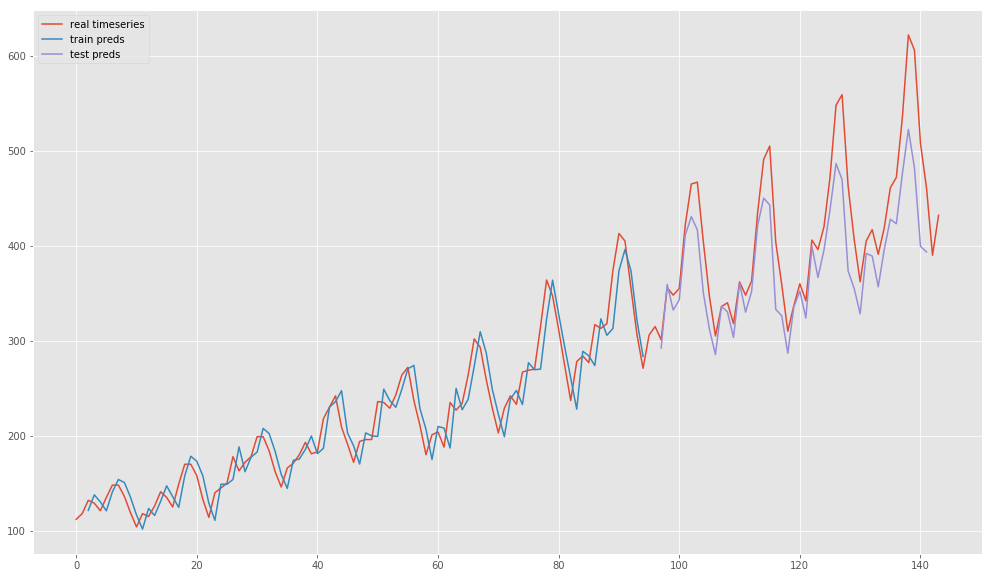

In [77]:
trainPredictPlot = numpy.empty_like(dataset) # предсказания для train'a
trainPredictPlot[:, :] = numpy.nan # заполняем пустыми значениями
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(dataset)-look_back-len(testPredict):len(dataset)-look_back, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='real timeseries')
plt.plot(trainPredictPlot, label='train preds')
plt.plot(testPredictPlot, label='test preds')
plt.legend()
plt.show()

## LSTM
![lstm](https://habrastorage.org/web/67b/04f/73b/67b04f73b4c34ba38edfa207e09de07c.png)

### Шаг 1
Определяем, что надо забыть из долгосрочной памяти

![](https://habrastorage.org/web/a5f/31a/104/a5f31a104b184217aca105de9ab6d320.png)

### Шаг 2
Определяем, какие элементы в долгосрочную память нужно добавить

![](https://habrastorage.org/web/248/bf4/a75/248bf4a75ab74bf180b9c0e2e2cc5a58.png)

### Шаг 3
Считаем эти элементы

![](https://habrastorage.org/web/30e/ffa/7f9/30effa7f98274deaa65cf2e293f18365.png)

### Шаг 4
Обновив долгосрочную память, определяем, что надо оставить в краткосрочной

![](https://habrastorage.org/web/16d/5b5/783/16d5b5783ba34244afcf0f240133fb28.png)

## Модификации

### Модификация 1

Учитывать долгосрочную память в остальных вычислениях

![](https://habrastorage.org/web/867/730/01d/86773001dcfe4fa5bb2a5e4959c00752.png)

### Модификация 2

Обновлять в долгосрочной памяти только те "ячейки", из которых на предыдущем шаге мы удаляли

![](https://habrastorage.org/web/832/da7/1b7/832da71b713b4664baac512f6efecefa.png)

### Модификация 3
GRU

![](https://cdn-images-1.medium.com/max/800/1*6eNTqLzQ08AABo-STFNiBw.png)

## Упражнение 2

In [78]:
from keras.layers import LSTM

# TODO проделайте все те же телодвижения с LSTM. Проверьте, есть ли прирост качества, и объясните полученные результаты

# TODO: проделываем те же махинации до стадии с обучением
dataset = pandas.read_csv('https://github.com/lazyprogrammer/machine_learning_examples/raw/master/airline/international-airline-passengers.csv', 
                          usecols=[1], engine='python', skipfooter=3)

# зафиксируем random_state для дальнейшей воспроизводимости эксперимента
numpy.random.seed(7)

dataset = dataset.values # Keras умеет хавать только numpy-матрицы
dataset = dataset.astype('float32')


# приведём все данные к интервалу значений от 0 до 1 (нормализуем)
# В принципе, если вы не используете регуляризацию, то можно не нормировать - результат будет тот же
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# разобьём данные на трейн и тест. 
# В задачах предсказания временный рядов это нужно делать осторожно, чтобы случайно не перемешать порядок данных!
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


# сконвертируем данные таким образом, чтобы для каждого временного тика (начиная с look_back) были добавлены 
# признаки для look_back предыдущих состояний
# def create_dataset(dataset, look_back=1) реализован выше
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# LSTM и RNN умеет работать с данными в таком формате [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# А вот и вся наша нейросетка :)
model = Sequential()
# model.add(SimpleRNN(4, batch_input_shape=(1, look_back, 1))) # 4 - размерность выхода, batch_input_shape = [batch_size, time steps, features]
model.add(LSTM(4, batch_input_shape=(1, 1, look_back))) # 4 - размерность выхода, batch_input_shape = [batch_size, features, time steps]
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



96 48


In [79]:
trainX.shape

(93, 1, 2)

In [80]:
NB_EPOCHES = 100
# Обучаем со сбросом состояний
for epoch in range(NB_EPOCHES):
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=1)
    model.reset_states()

Epoch 1/1
93/93 [==============================] - 0s 1ms/step - loss: 0.0371
Epoch 1/1
93/93 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 1/1
93/93 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 1/1
93/93 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 1/1
93/93 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 1/1
93/93 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 1/1
93/93 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 1/1
93/93 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 1/1
93/93 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 1/1
93/93 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 1/1
93/93 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 1/1
93/93 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 1/1
93/93 [==============================] - 0s 2ms/step -

In [81]:
# TODO: посмотрите на качество предсказаний

# получим предсказания
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# преобразуем обратно наши данные из интервала (0, 1) в исходных диапазон значений
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# посчитаем MSE для наших предсказаний
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 24.41 RMSE
Test Score: 53.30 RMSE


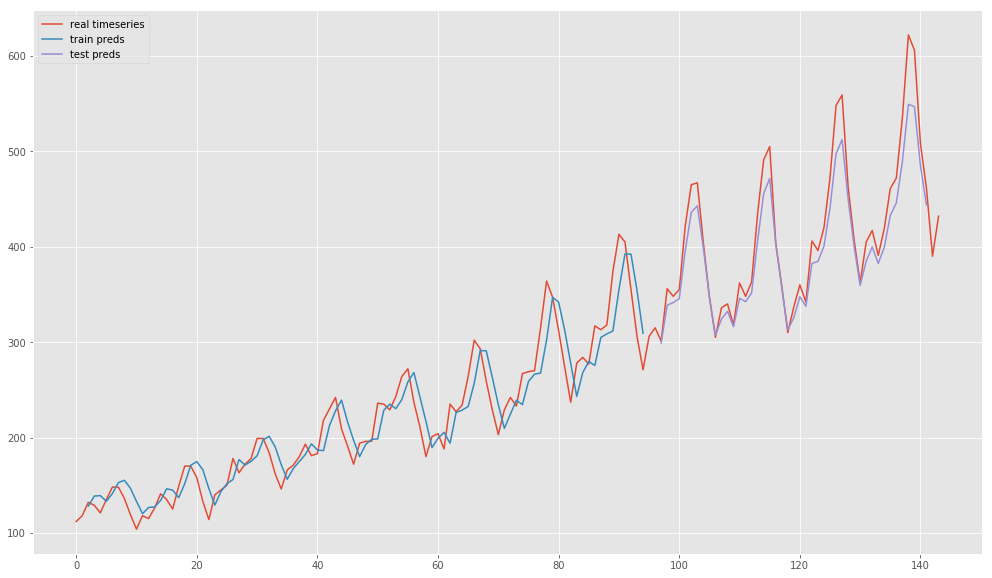

In [82]:
trainPredictPlot = numpy.empty_like(dataset) # предсказания для train'a
trainPredictPlot[:, :] = numpy.nan # заполняем пустыми значениями
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(dataset)-look_back-len(testPredict):len(dataset)-look_back, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='real timeseries')
plt.plot(trainPredictPlot, label='train preds')
plt.plot(testPredictPlot, label='test preds')
plt.legend()
plt.show()

# Полезные ссылки
* [Статья](https://habrahabr.ru/company/wunderfund/blog/331310/) про RNN и LSTM на Хабре
* [Статья](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) с подробным разбором примера на Keras